# Heston Models

Both prices and volatility are modelled by Geometric Browian motion

$$dS_t = \mu S_tdt + \sqrt{v_t}S_tdW_{s,t}$$

$$dv_t = \kappa(\theta - v_t)dt + \sigma \sqrt{v_t}dW_{v,t}$$

- $\sigma$ volatility of volaility
- $\theta$ long term price variance
- $\kappa$ rate of reversion to long term price variance
- $dW_{s,t}$ Browian motion of price
- $dW_{v,t}$ Browian motion of price variance
- $\rho$ correlation between $dW_{s,t}$ and $dW_{v,t}$

## Euler Discretisation of SDEs

https://frouah.com/finance%20notes/Euler%20and%20Milstein%20Discretization.pdf

The SDE can be converted to

$$S_{i+1} = S_i \exp{\left(\left(r-\frac{v_i}{2}\right)\Delta t + \sqrt{v_i \Delta t} \Delta W_{s,i+1}\right)}$$

$$v_{i+1} = v_i + \kappa (\theta - v_t)\Delta t + \sigma \sqrt{v_i \Delta }t \Delta W_{v,i+1}


## Monte Carlo Simulation

Based on above formula, we can simulation the asset's price and asset's variance price

In [17]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from py_vollib_vectorized import vectorized_implied_volatility as implied_vol

In [18]:
# Parameters
# simulation dependent
S0 = 100.0             # asset price
T = 1.0                # time in years
r = 0.02               # risk-free rate
N = 252                # number of time steps in simulation
M = 1000               # number of simulations

# Heston dependent parameters
kappa = 3              # rate of mean reversion of variance under risk-neutral dynamics
theta = 0.20**2        # long-term mean of variance under risk-neutral dynamics
v0 = 0.25**2           # initial variance under risk-neutral dynamics
rho = 0.7              # correlation between returns and variances under risk-neutral dynamics
sigma = 0.6            # volatility of volatility
theta, v0

(0.04000000000000001, 0.0625)

In [25]:
def heston_model_sim(S0, v0, rho, kappa, theta, sigma,T, N, M):
    """
    Inputs:
     - S0, v0: initial parameters for asset and variance
     - rho   : correlation between asset returns and variance
     - kappa : rate of mean reversion in variance process
     - theta : long-term mean of variance process
     - sigma : vol of vol / volatility of variance process
     - T     : time of simulation
     - N     : number of time steps
     - M     : number of scenarios / simulations
    
    Outputs:
    - asset prices over time (numpy array)
    - variance over time (numpy array)
    """
    # initialise other parameters
    dt = T/N
    mu = np.array([0,0])
    cov = np.array([[1,rho],
                    [rho,1]])
    # arrays for storing prices and variances
    S = np.full(shape=(N+1,M), fill_value=S0)
    v = np.full(shape=(N+1,M), fill_value=v0)
    # sampling correlated brownian motions under risk-neutral measure
    Z = np.random.multivariate_normal(mu, cov, (N,M))
    for i in range(1,N+1):
        S[i] = S[i-1] * np.exp( (r - 0.5*v[i-1])*dt + np.sqrt(v[i-1] * dt) * Z[i-1,:,0] )
        v[i] = np.maximum(v[i-1] + kappa*(theta-v[i-1])*dt + sigma*np.sqrt(v[i-1] *dt) * Z[i-1,:,1],0)
    
    return S, v

In [26]:
rho_p = 0.98
rho_n = -0.98
S_p,v_p = heston_model_sim(S0, v0, rho_p, kappa, theta, sigma,T, N, M)
S_n,v_n = heston_model_sim(S0, v0, rho_n, kappa, theta, sigma,T, N, M)

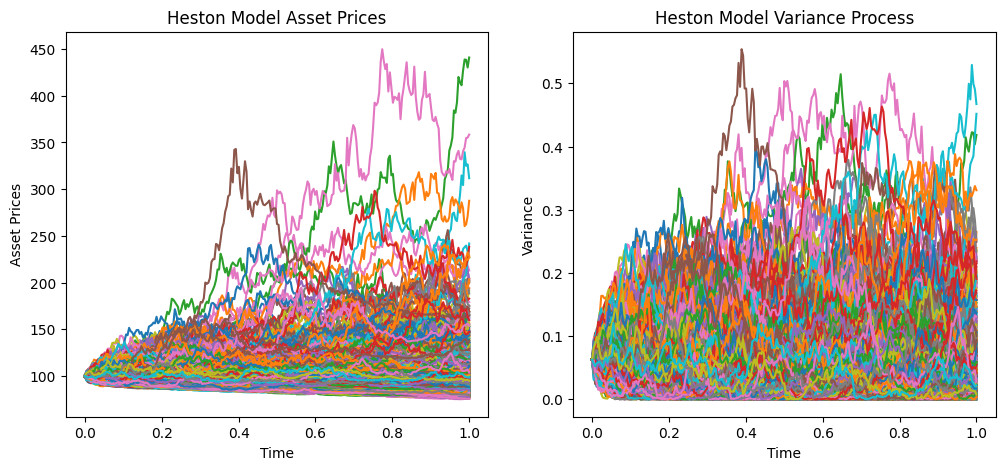

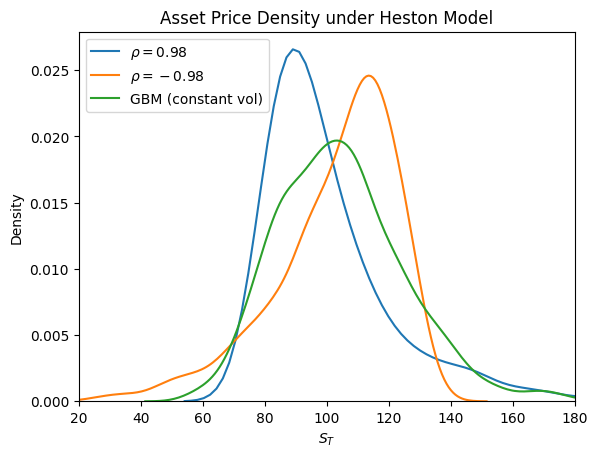

In [33]:
fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(12,5))
time = np.linspace(0,T,N+1)
ax1.plot(time,S_p)
ax1.set_title('Heston Model Asset Prices')
ax1.set_xlabel('Time')
ax1.set_ylabel('Asset Prices')
ax2.plot(time,v_p)
ax2.set_title('Heston Model Variance Process')
ax2.set_xlabel('Time')
ax2.set_ylabel('Variance')
plt.show()

# simulate gbm process at time T
gbm = S0*np.exp( (r - theta**2/2)*T + np.sqrt(theta)*np.sqrt(T)*np.random.normal(0,1,M) )
fig, ax = plt.subplots()
ax = sns.kdeplot(S_p[-1], label=r"$\rho= 0.98$", ax=ax)
ax = sns.kdeplot(S_n[-1], label=r"$\rho= -0.98$", ax=ax)
ax = sns.kdeplot(gbm, label="GBM (constant vol)", ax=ax)
plt.title(r'Asset Price Density under Heston Model')
plt.xlim([20, 180])
plt.xlabel('$S_T$')
plt.ylabel('Density')
plt.legend()
plt.show()

## Capturing the Volatililty Smile in Option Pricing
1. Compute the possible prices path based on Heston models
2. For each strike price, compute expected values of options value based on all possible paths from Heston model
3. Given option value, compute IV
4. Plot the IV

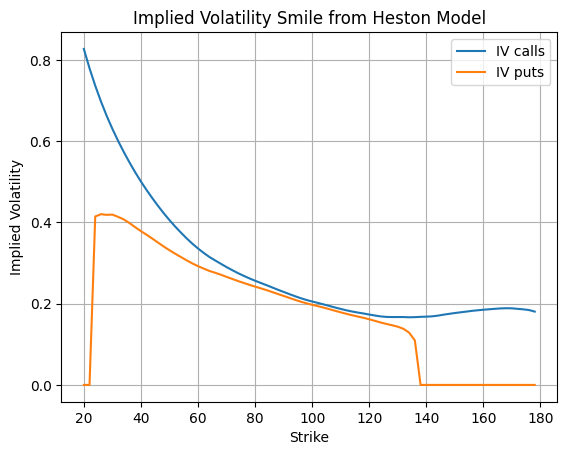

In [53]:
rho = -0.7
S,v = heston_model_sim(S0, v0, rho, kappa, theta, sigma,T, N, M)
# Set strikes and complete MC option price for different strikes
K = np.arange(20,180,2)
puts = np.array([np.exp(-r*T)*np.mean(np.maximum(k-S[-1],0)) for k in K])
calls = np.array([np.exp(-r*T)*np.mean(np.maximum(S[-1]-k,0)) for k in K])
put_ivs = implied_vol(puts, S0, K, T, r, flag='p', q=0, return_as='numpy', on_error='ignore')
call_ivs = implied_vol(calls, S0, K, T, r, flag='c', q=0, return_as='numpy')
plt.plot(K, call_ivs, label=r'IV calls')
plt.plot(K, put_ivs, label=r'IV puts')
plt.ylabel('Implied Volatility')
plt.xlabel('Strike')
plt.title('Implied Volatility Smile from Heston Model')
plt.legend()
plt.grid()
plt.show()